# 価値反復法(value iteration)の考え方を迷路問題を用いて確認する

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from common.meiro import Environment, State
from common.planner import Planner

In [2]:
class ValueIterationPlanner(Planner):
    """
    価値反復法を用いて、価値を更新していくためのクラス
    """
    def __init__(self, env):
        # Plannerクラスの__init__関数を実行する
        super().__init__(env) 

    def plan(self, gamma=0.9, threshold=0.0001):
        """
        各セルの価値を求めるメソッド
        """
        self.gamma = gamma
        
        # 初期化
        self.initialize()
        actions = self.env.actions
        
        # 価値Vの初期化
        V = {}
        for s in self.env.states:
            V[s] = 0
            
        # 価値を更新するループ
        while True:
            delta = 0

            states = V.keys()
            for s in states:
                """
                全状態のループ
                """
                
                if not self.env.can_action_at(s):
                    """
                    通常セル以外はスキップする
                    """
                    continue


                expected_return = []
                for a in actions:
                    """
                    全行動のループ
                    """
                    
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):                      
                        """
                        ある状態sにおいてある行動aをとった場合のとりうるnext_stateのループ
                        """
                        # そのnext_stateをとる確率 * 収益
                        r += prob * (reward + gamma * V[next_state])
                        
                    # 期待収益
                    expected_return.append(r)
                    
                # 期待収益の最大値をその状態の価値にする
                max_reward = max(expected_return)
                delta = max(delta, abs(max_reward - V[s]))# 価値の変化量
                V[s] = max_reward
                
            # 価値の変化量deltaが閾値未満になったら終了
            if delta < threshold:
                break

        # dict形式のVを2次元配列に変換する
        V_grid = self.dict_to_array(V)
        
        # policyメソッドで利用するために記憶しておく
        self.V = V
        
        return V_grid


    def policy(self, s):
        """
        学習後に、ある状態に対する最適な行動を出力するためのメソッド
        s : 状態
        """
        if not hasattr(self, 'V'):
            print("価値Vの計算結果が存在しません. planを実行してください")
            return None
        
        actions = self.env.actions
        V = self.V
        gamma = self.gamma
        
        # 引数で与えられた状態sに関する行動価値を初期化
        Q_s = [0] * len(actions)
                    
        # 学習された状態価値を使って各行動に関する行動価値を計算
        for a in actions:
            for prob, next_state, reward in self.transitions_at(s, a):
                Q_s[a] = prob * (reward + gamma * V[next_state])
                
        # 最適な行動を出力
        return np.argmax(Q_s)


## 実行

In [3]:
import time
start = time.time()

# 迷路の条件を設定する
grid = np.array([[0,0,0,1],[0,9,0,-1],[0,0,0,0]])

# 環境をつくる
env = Environment(grid, move_prob=0.95)

# 価値反復法のオブジェクトをつくる( 価値反復法において、エージェントは不要 )
planner = ValueIterationPlanner(env)

# 価値反復法を実行する
result = planner.plan()

# 実行時間
elapsed_time = time.time() - start
print ("elapsed_time:{:.3f}".format(elapsed_time) + "[sec]")

# 学習した結果を用いて、ある状態に関する最適な行動を出力させる
planner.policy(State(0,0))

elapsed_time:0.007[sec]


3

## 結果の可視化

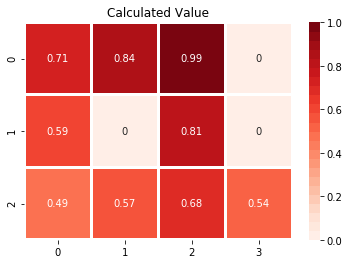

In [4]:
import seaborn as sns
sns.heatmap(result, annot=True, linewidths=2, vmin=0, vmax=1, cmap=sns.color_palette("Reds", 24))
plt.title("Calculated Value")
plt.show()

* 計算結果は方策反復法と同じになるが、計算ステップが少なく済む分、計算時間が短くなる